# Import packages

## General

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Personal

In [2]:
from rbm.utils import Predictions, Compiler

# Define vars

In [3]:
datasets = ['test', 'newcancer']
metrics = ['precision', 'recall', 'f1', 'auc']

# Define Funcs

## Compiling results

In [4]:
def getResults(predPath, metrics):
    preds = pd.read_csv(predPath, index_col=0)
    Evaluator = Predictions(None)
    cellLineResults = Evaluator._cellLinePerformance(preds, metrics)
    cancerResults = Evaluator._cancerTypePerformance(cellLineResults) 
    return cellLineResults, cancerResults

def iterateModelPreds(basePath, dataset, metrics):
    predDir = os.path.join(basePath, f"{dataset}_preds")
    resultDir = os.path.join(basePath, f"{dataset}_results")
    files = os.listdir(predDir)
    for f in files:
        predPath = os.path.join(predDir, f)
        modelName = "_".join(f.split('_')[:-1])
        cellLinePath = os.path.join(resultDir, f"{modelName}_CLresults.csv")
        cancerPath = os.path.join(resultDir, f"{modelName}_CancerResults.csv")
        cellLineResults, cancerResults = getResults(predPath, metrics)
        cellLineResults.to_csv(cellLinePath)
        cancerResults.to_csv(cancerPath)
        
def compileResults(basePath, modelType, subdir, prefix, suffix='CancerResults.csv'):
    compiler = Compiler(basePath, modelType)
    compiler.compileResults(subdir, prefix, suffix)

In [5]:
def getResultsAndCompile(basePath, modelType, prefix, datasets, metrics):
    for d in datasets:
        iterateModelPreds(basePath, d, metrics)
        subdir = f"{d}_res"
        compileResults(basePath, modelType, subdir, prefix)

## precision@k

In [16]:
def precision(predPath, modelName, thresh):
    p1 = []
    p2 = []
    p3 = []
    p4 = []
    p5 = []
    p0 = []
    cellLines = []
    predDF = pd.read_csv(predPath, index_col=0)
    for cell, subdf in predDF.groupby(by='cell_line'):
        nEff = subdf.true.sum()
        if nEff < 5:
            continue
        cellLines.append(cell)
        sortDF = subdf.sort_values(by='pred', ascending=False)
        p1.append(sortDF.iloc[:1, :].true.sum() / 1)
        p2.append(sortDF.iloc[:2, :].true.sum() / 2)
        p3.append(sortDF.iloc[:3, :].true.sum() / 3)
        p4.append(sortDF.iloc[:4, :].true.sum() / 4)
        p5.append(sortDF.iloc[:5, :].true.sum() / 5)
        if sortDF.true.sum() >= 10:
            p0.append(sortDF.iloc[:10, :].true.sum() / 10)
    
    if np.mean(p5) >= thresh:
        print(f"Model: {modelName}")
        thresh = np.mean(p5)
        print(f"\tPrecision@1: {round(thresh, 4)}")
        print(f"\tPrecision@2: {round(np.mean(p2), 4)}")
        print(f"\tPrecision@3: {round(np.mean(p3), 4)}")
        print(f"\tPrecision@4: {round(np.mean(p4), 4)}")
        print(f"\tPrecision@5: {round(np.mean(p5), 4)}")
        print(f"\tPrecision@10: {round(np.mean(p0), 4)}\n\n")
           
    df = pd.DataFrame({'p@1':p1, 'p@2':p2, 'p@3':p3, 'p@4':p4, 'p@5':p5}, index=cellLines)
    return thresh, df
    
    
def iteratePrecision(basePath, file=None, thresh=0.7):
    if file == None:
        files = os.listdir(basePath)
    else: 
        files = [file]
    for f in files:
        thresh, df = precision(os.path.join(basePath, f), f, thresh)
    print(thresh)
    
    if file != None:
        return df

# FS-CDR

In [7]:
modelType = 'fsCDR'
prefix = 'Fused-FewShotCDR'
basePath = '/fs/scratch/PCON0041/PatrickLawrence/cancer-drug-response/fewShot/cdr/v2'

## Compile

In [8]:
#getResultsAndCompile(basePath, modelType, prefix, datasets, metrics)

## Precision@k

In [15]:
# Average of 50 cell lines with cancer types seen during training
iteratePrecision(os.path.join(basePath, 'test_preds'), thresh=0.75)

0.75


In [10]:
bestModel = 'Fused-FewShotCDR_NL64_16_DO0-1_AFsigmoid_LR0-01_DR0-99_DS500_preds.csv'

In [11]:
df = iteratePrecision(os.path.join(basePath, 'test_preds'), file=bestModel, thresh=0.8)
cl = df.index

Model: Fused-FewShotCDR_NL64_16_DO0-1_AFsigmoid_LR0-01_DR0-99_DS500_preds.csv
	Precision@1: 0.8039
	Precision@2: 0.6471
	Precision@3: 0.6078
	Precision@4: 0.5735
	Precision@5: 0.5294
	Precision@10: 0.459


0.803921568627451


In [46]:
ctypes = pd.read_csv(os.path.join(basePath, 'test_preds', bestModel), index_col=0).loc[:, ['cell_line', 'cancer_type']].drop_duplicates(keep='first').set_index('cell_line').cancer_type
df.insert(0, 'cancerType', ctypes)


,cancerType,p@1,p@2,p@3,p@4,p@5
ACH-000012,Lung Cancer,1.0,1.0,1.000000,1.00,1.0
ACH-000062,Lung Cancer,1.0,0.5,0.666667,0.75,0.6
ACH-000086,Lung Cancer,1.0,0.5,0.333333,0.25,0.4
ACH-000161,Lung Cancer,1.0,0.5,0.666667,0.50,0.4
ACH-000164,Pancreatic Cancer,0.0,0.0,0.000000,0.00,0.2


In [48]:
df.sort_values(by=['p@1', 'p@2', 'p@3', 'p@4', 'p@5'], ascending=False, inplace=True)
df.head(10)

,cancerType,p@1,p@2,p@3,p@4,p@5
ACH-000012,Lung Cancer,1.0,1.0,1.0,1.00,1.0
ACH-000860,Lung Cancer,1.0,1.0,1.0,1.00,1.0
ACH-000984,Endometrial/Uterine Cancer,1.0,1.0,1.0,1.00,1.0
ACH-000280,Ovarian Cancer,1.0,1.0,1.0,1.00,0.8
ACH-000747,Lung Cancer,1.0,1.0,1.0,1.00,0.8
ACH-000749,Lung Cancer,1.0,1.0,1.0,1.00,0.8
ACH-000788,Skin Cancer,1.0,1.0,1.0,1.00,0.8
ACH-000982,Colon/Colorectal Cancer,1.0,1.0,1.0,1.00,0.8
ACH-000421,Colon/Colorectal Cancer,1.0,1.0,1.0,0.75,0.6
ACH-000527,Ovarian Cancer,1.0,1.0,1.0,0.75,0.6


In [49]:
df.tail(5)

,cancerType,p@1,p@2,p@3,p@4,p@5
ACH-000305,Esophageal Cancer,0.0,0.0,0.333333,0.25,0.4
ACH-000663,Ovarian Cancer,0.0,0.0,0.333333,0.25,0.2
ACH-000164,Pancreatic Cancer,0.0,0.0,0.000000,0.00,0.2
ACH-000329,Brain Cancer,0.0,0.0,0.000000,0.00,0.2
ACH-000824,Esophageal Cancer,0.0,0.0,0.000000,0.00,0.0


In [52]:
df.mean()

p@1    0.807692
p@2    0.644231
p@3    0.602564
p@4    0.567308
p@5    0.526923
dtype: float64

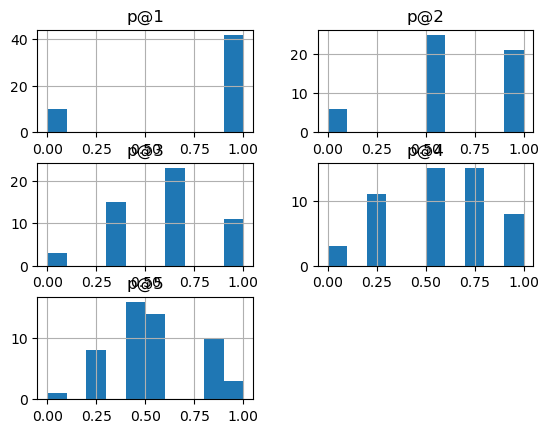

In [51]:
df.hist()
plt.show()

In [39]:
drugCount = {}
for cell, subdf in predDF.groupby(by='cell_line'):
    sortDF = subdf.sort_values(by='pred', ascending=False).reset_index(drop=True)
    drug = sortDF.loc[0, 'drug']
    if drug in drugCount.keys():
        drugCount[drug] += 1
    else:
        drugCount[drug] = 1
        
    if sortDF.iloc[:5, :].true.sum() == 0:
        print(f"\nNo true effective drugs identified in top 5 for {cell}")
        print(f"Cell line: {sortDF.loc[0, 'cell_line']}; Top drug: {drug}\n")
    else:
        print(f"Cell line: {sortDF.loc[0, 'cell_line']}; Top drug: {drug}")


Cell line: ACH-000012; Top drug: nemorubicin
Cell line: ACH-000062; Top drug: mitoxantrone
Cell line: ACH-000086; Top drug: YM-155
Cell line: ACH-000161; Top drug: genz-644282

No true effective drugs identified in top 5 for ACH-000164
Cell line: ACH-000164; Top drug: JNJ-26481585

Cell line: ACH-000222; Top drug: genz-644282
Cell line: ACH-000280; Top drug: topotecan
Cell line: ACH-000305; Top drug: beta-lapachone
Cell line: ACH-000316; Top drug: YM-155
Cell line: ACH-000320; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000329; Top drug: 10-hydroxycamptothecin
Cell line: ACH-000347; Top drug: YM-155
Cell line: ACH-000368; Top drug: echinomycin
Cell line: ACH-000376; Top drug: nemorubicin
Cell line: ACH-000421; Top drug: genz-644282
Cell line: ACH-000450; Top drug: CID-5458317
Cell line: ACH-000467; Top drug: genz-644282
Cell line: ACH-000486; Top drug: irinotecan
Cell line: ACH-000493; Top drug: topotecan
Cell line: ACH-000510; Top drug: beta-lapachone
Cell line: ACH-000527; Top dr

In [36]:
drugCount

{'epothilone-b': 11,
 'echinomycin': 9,
 'YM-155': 19,
 'genz-644282': 5,
 'pardoprunox': 1,
 '10-hydroxycamptothecin': 2,
 'nemorubicin': 2,
 'valnemulin': 1,
 'topotecan': 1,
 'ICG-001': 1}

In [80]:
predDF[predDF.drug == 'TAS-103'].sort_values(by='pred', ascending=False)

,cell_line,cancer_type,drug,true,pred
6593,ACH-000834,Bladder Cancer,TAS-103,0,0.531032
6573,ACH-000651,Colon/Colorectal Cancer,TAS-103,0,0.470912
6579,ACH-000788,Skin Cancer,TAS-103,0,0.455642
6583,ACH-000776,Brain Cancer,TAS-103,0,0.432243
6591,ACH-000665,Lung Cancer,TAS-103,0,0.406337
6584,ACH-000486,Bladder Cancer,TAS-103,0,0.401862
6574,ACH-000570,Brain Cancer,TAS-103,0,0.400453
6587,ACH-000012,Lung Cancer,TAS-103,0,0.389942
6590,ACH-000563,Lung Cancer,TAS-103,0,0.389818
6592,ACH-000467,Colon/Colorectal Cancer,TAS-103,0,0.386398


In [91]:
drugCount

{'epothilone-b': 11,
 'echinomycin': 9,
 'YM-155': 19,
 'genz-644282': 5,
 'pardoprunox': 1,
 '10-hydroxycamptothecin': 2,
 'nemorubicin': 2,
 'valnemulin': 1,
 'topotecan': 1,
 'ICG-001': 1}

In [58]:
df = iteratePrecision(os.path.join(basePath, 'newcancer_preds'), file=bestModel)

Model: Fused-FewShotCDR_NL64_16_DO0-1_AFsigmoid_LR0-01_DR0-99_DS500_preds.csv
	Precision@1: 0.7077
	Precision@2: 0.6308
	Precision@3: 0.6
	Precision@4: 0.5846
	Precision@5: 0.5262
	Precision@10: 0.4922


0.7076923076923077


In [89]:
# Average of 67 cell lines with cancer types not seen during training
iteratePrecision(os.path.join(basePath, 'newcancer_preds'), thresh=0.65)

Model: Fused-FewShotCDR_NL64_16_DO0-1_AFsigmoid_LR0-01_DR0-99_DS500_preds.csv
	Precision@1: 0.6866
	Precision@2: 0.6119
	Precision@3: 0.5821
	Precision@4: 0.5672
	Precision@5: 0.5104
	Precision@10: 0.4922


Model: Fused-FewShotCDR_NL64_32_DO0-0_AFrelu_LR0-001_DR0-99_DS500_preds.csv
	Precision@1: 0.6866
	Precision@2: 0.6567
	Precision@3: 0.592
	Precision@4: 0.5597
	Precision@5: 0.5343
	Precision@10: 0.4961


Model: Fused-FewShotCDR_NL64_16_DO0-0_AFrelu_LR0-001_DR0-99_DS500_preds.csv
	Precision@1: 0.7164
	Precision@2: 0.6269
	Precision@3: 0.602
	Precision@4: 0.5672
	Precision@5: 0.5343
	Precision@10: 0.4902


0.7164179104477612


In [47]:
'Fused-FewShotCDR_NL64_16_DO0-1_AFsigmoid_LR0-01_DR0-99_DS500_preds.csv'

'Fused-FewShotCDR_NL64_16_DO0-1_AFsigmoid_LR0-01_DR0-99_DS500_preds.csv'